# Biblioteca

In [1]:
import pandas as pd
import numpy as np
from scipy import interpolate
from tabulate import tabulate
from tqdm import notebook
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,8)
plt.style.use('seaborn-whitegrid')

import os

# Ler Excel

In [2]:
local_excel = './data/sine.xls'

In [3]:
import xlrd
xls = xlrd.open_workbook(local_excel, on_demand=True)
sheet_names = xls.sheet_names() # <- remeber: xlrd sheet_names is a function, not a property
print (sheet_names)

['24AUG21-LG1ZS01.001', '24AUG21-LG2ZS01.001', '24AUG21-LG2ZS01.002', '24AUG21-LG2ZS01.003', '24AUG21-LG2ZS01.004', '24AUG21-LG2ZS01.005', 'FULL']


In [4]:
excel_file = local_excel
dict_df = {}
for i in sheet_names:
    df = pd.read_excel(excel_file, sheet_name=i)
    dict_df[i] = df
print (dict_df)

{'24AUG21-LG1ZS01.001':       %Freq(Hz)   REFERENCE   CONTROL     DRIVE       CHANNEL  1       \
0        5.00000    0.503501    0.479733    0.263027         0.479733   
1        5.01501    0.506991    0.479733    0.264850         0.479733   
2        5.04516    0.512861    0.483059    0.266686         0.483059   
3        5.06031    0.516416    0.489779    0.268534         0.489779   
4        5.07550    0.518800    0.496592    0.270396         0.496592   
...          ...         ...         ...         ...              ...   
1990  1976.17000    1.000000    1.002310    0.011722         1.002310   
1991  1982.10000    1.000000    1.002310    0.011194         1.002310   
1992  1988.05000    1.000000    1.002310    0.010617         1.002310   
1993  1994.01000    1.000000    1.002310    0.010162         1.002310   
1994  2000.00000    1.000000    1.002310    0.010162         1.002310   

      CHANNEL  3       
0            0.464515  
1            0.464515  
2            0.467735  
3  

## Explorando Dataframes

### Seno

In [5]:
df_sine = dict_df['FULL'].set_index('FREQ') # Slecionando os dados random

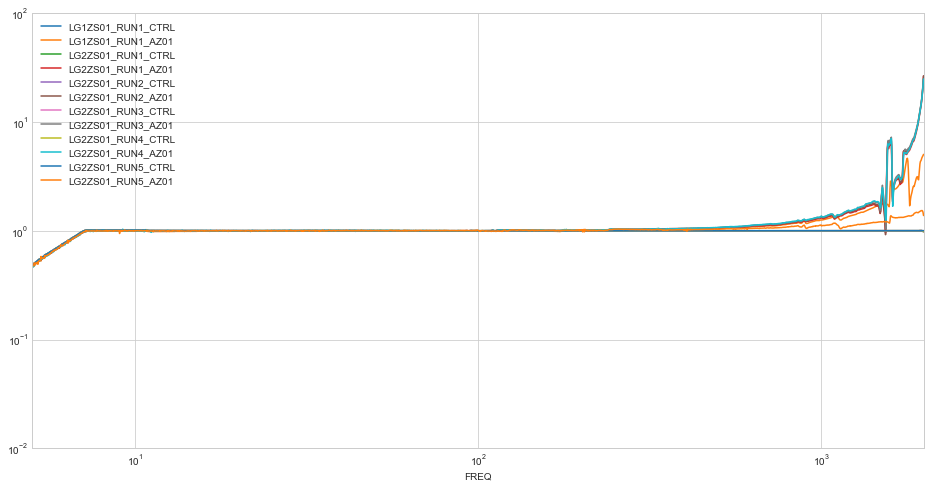

In [6]:
df_sine.plot()
plt.xlim(5, 2000)
plt.ylim(0.01, 100)
plt.yscale("log")
plt.xscale("log")

*****

## Funcao Comparativo

### Ler o excel

In [7]:
xls = xlrd.open_workbook(local_excel, on_demand=True)
sheet_names = xls.sheet_names() # <- remeber: xlrd sheet_names is a function, not a property
print (sheet_names)

excel_file = local_excel
dict_df = {}
for i in sheet_names:
    df = pd.read_excel(excel_file, sheet_name=i)
    dict_df[i] = df

['24AUG21-LG1ZS01.001', '24AUG21-LG2ZS01.001', '24AUG21-LG2ZS01.002', '24AUG21-LG2ZS01.003', '24AUG21-LG2ZS01.004', '24AUG21-LG2ZS01.005', 'FULL']


In [8]:
df_sine = dict_df['FULL'].set_index('FREQ') # Selecionando os dados random

### Seno

In [9]:
def comparativo_sine(data, erro_lab,titulo, plot_diff=True, print_output=True,
                   size_text=11, size=(8,15), xlim=[5,2000], ylim=[0.01, 10], dpi=100):
    """
    Plota comparativo dos dados de vibraçao (senoidal e choque).
    -----
    data = dataframe com os dados dos dois ensaios
    erro_lab = erro laboratorial em decimal Ex.: 0.10 (10%)
    plot_diff = condicao para plotar ou nao o grafico com o erro (True ou False)
    print_output = condicao para mostrar os dados do gmrs total e o valor do erro normalizado no grafico (True ou False)
    size_text = tamanho da fonte 
    size = tamanho do grafico
    xlim = limites do eixo x
    ylim = limites do eixo y
    -----
    """
    
    columns = data.columns # Adquiri as colunas do dataframe
    erro = (data[columns[0]] - data[columns[1]]) # Calcula o erro 1a coluna menos a 2 coluna
    
    max_ind = erro.abs().idxmax() # indice (Hz) do valor maximo
    max_value = erro.loc[max_ind] # valor maximo
    
    fig = plt.figure(dpi=dpi)
    
    if plot_diff == False:
        fig.set_figheight(size[1]*0.95) # Altura da imagem
    else:    
        fig.set_figheight(size[0]) # Altura da imagem
    
    fig.set_figwidth(size[1]) # Largura da imagem
        
    # calculo do grms e construcao de um dataframe e o calculo do erro normalizado
    max_ind = erro.abs().idxmax()
    max_value = erro.loc[max_ind]
    
    max_1 = data[columns[0]].loc[max_ind]
    max_2 = data[columns[1]].loc[max_ind]
    output = pd.DataFrame(index=data.columns)
    output['Max. Dif. (g) - En'] = [max_1, max_2]
    output['Incert. Expand. - Un'] = [max_1 * erro_lab, max_2 * erro_lab]
    #output['En'] = [max_1, max_2]
    #output['Un'] = [max_1 * erro_lab, max_2 * erro_lab]
    
    
    En = abs(output['Max. Dif. (g) - En'].diff()[1]) / np.sqrt((output['Incert. Expand. - Un'] ** 2).sum()) 
    print(f'{round(output,3)}\n\nErro Nomalizado: {round(En,3)}')
    #En = abs(output['En'].diff()[1]) / np.sqrt((output['Un'] ** 2).sum()) 
    #print(f'{round(output,3)}\n\nErro Nomalizado: {round(En,3)}')
       
    ax1 = plt.subplot2grid(shape=(3, 3), loc=(0, 0), colspan=3, rowspan=2)
    ax1.plot(data)
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.legend(data.columns)
    ax1.set_ylabel('[g]')
    ax1.title.set_text(titulo)
    # condicao para mostrar o dataframe com os dados dos valores grms e erro normalizado
    if print_output == True:
        output.index = [i.split('_')[0] for i in output.index] # Simplificando o index
        output=output.reset_index().rename(columns = {'index':'Ensaio'})
        output = tabulate(round(output, 4), headers='keys', numalign='center') # Transformar para formato tabular para printar no grafico
        ax1.annotate(f'Erro laboratorial: {round(erro_lab,4)}\n\n{output}\n\nErro Nomalizado: {round(En,4)}',
                     (xlim[0]*1.1 ,ylim[0]*1.5), size=size_text); # horizontal alignment can be left, right or center
    # condicao para mostrar o grafico do erro entre os dois testes
    if plot_diff == True:
        ax2 = plt.subplot2grid(shape=(3, 3), loc=(2, 0), colspan=3, rowspan=1) 
        ax2.plot(erro, '--', label=erro.name, linewidth=1) # Dados principais Interpolados
        ax2.axvline(x=max_ind, c='magenta', alpha=0.3, zorder=1) # data do ponto maximo
        ax2.scatter(max_ind, max_value, c='magenta', linewidths=1)
        ax2.set_xlim(xlim)
        ax2.set_xscale('log')
        # anotacao do valor maximo e a respectiva frequencia do erro entre os ensaios
        ax2.annotate(f'Max value:{round(max_value,4)} g \n@ Freq.: {max_ind} Hz', # this is the text
                         (max_ind, max_value), # this is the point label
                         textcoords='offset points', # how to position the text
                         xytext=(10,0), # distance from text to points (x,y)
                         ha='left',
                         size=size_text); # horizontal alignment can be left, right or center
        ax2.set_xlabel('Frequencia [Hz]')
        ax2.set_ylabel('Erro [g]');
    
    try:
        os.mkdir('./img/sine')
    except:
        pass
    
    plt.savefig(f'./img/sine/{data.columns[0]} x {data.columns[1]}', dpi=dpi, bbox_inches='tight')
    
    return (output, En)

# Resultados

## Controle

In [10]:
erro_lab = 0.104970601724674

In [11]:
# Paramns
print_output = True
size_text=11
xlim=[5, 2000]
ylim=[0.01, 100]

In [12]:
print(list(df_sine.columns))
print(sheet_names)

['LG1ZS01_RUN1_CTRL', 'LG1ZS01_RUN1_AZ01', 'LG2ZS01_RUN1_CTRL', 'LG2ZS01_RUN1_AZ01', 'LG2ZS01_RUN2_CTRL', 'LG2ZS01_RUN2_AZ01', 'LG2ZS01_RUN3_CTRL', 'LG2ZS01_RUN3_AZ01', 'LG2ZS01_RUN4_CTRL', 'LG2ZS01_RUN4_AZ01', 'LG2ZS01_RUN5_CTRL', 'LG2ZS01_RUN5_AZ01']
['24AUG21-LG1ZS01.001', '24AUG21-LG2ZS01.001', '24AUG21-LG2ZS01.002', '24AUG21-LG2ZS01.003', '24AUG21-LG2ZS01.004', '24AUG21-LG2ZS01.005', 'FULL']


                   Max. Dif. (g) - En  Incert. Expand. - Un
LG1ZS01_RUN1_CTRL               1.002                 0.105
LG2ZS01_RUN1_CTRL               0.982                 0.103

Erro Nomalizado: 0.14


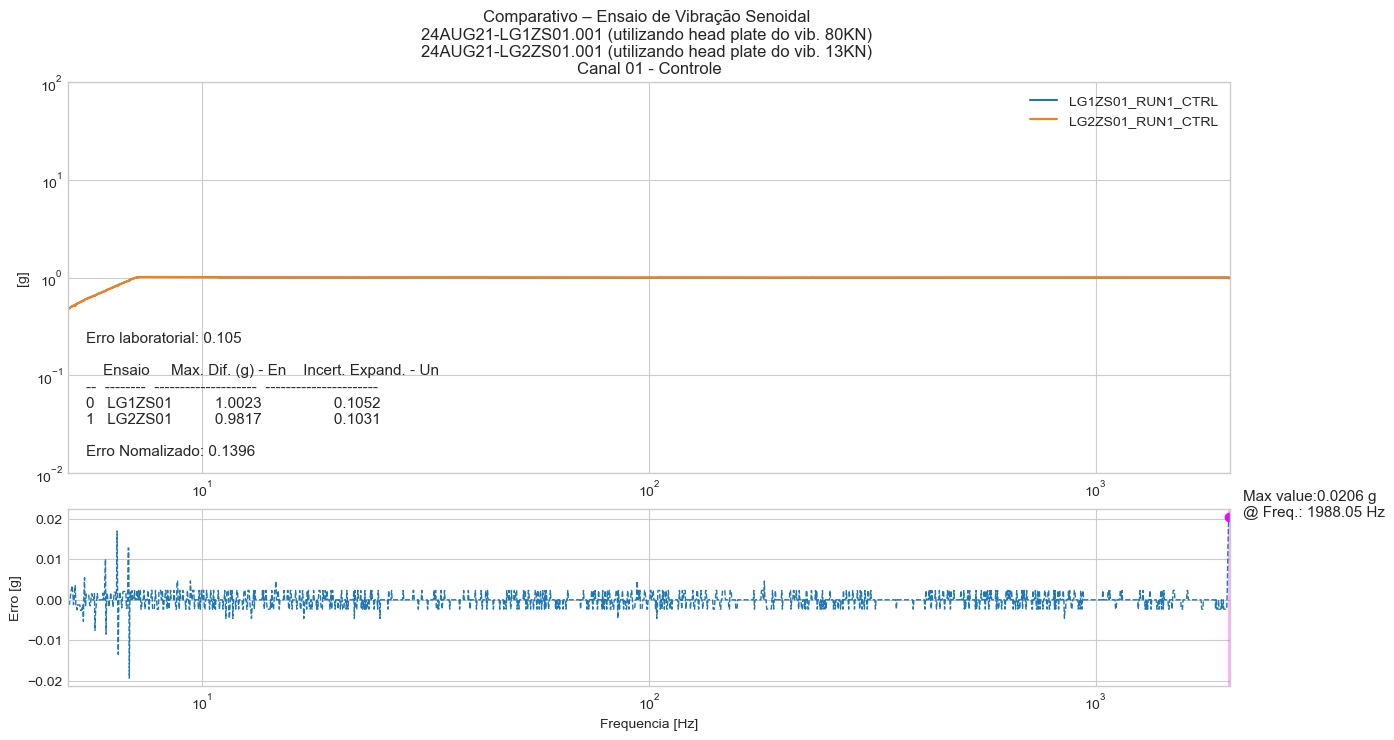

In [13]:
data = df_sine[['LG1ZS01_RUN1_CTRL', 'LG2ZS01_RUN1_CTRL']]
titulo = 'Comparativo – Ensaio de Vibração Senoidal \n\
24AUG21-LG1ZS01.001 (utilizando head plate do vib. 80KN) \n\
24AUG21-LG2ZS01.001 (utilizando head plate do vib. 13KN) \n\
Canal 01 - Controle'

output, En = comparativo_sine(data, erro_lab, titulo, print_output=print_output, size_text=size_text, xlim=xlim, ylim=ylim)

                   Max. Dif. (g) - En  Incert. Expand. - Un
LG1ZS01_RUN1_AZ01               5.035                 0.529
LG2ZS01_RUN1_AZ01              26.424                 2.774

Erro Nomalizado: 7.575


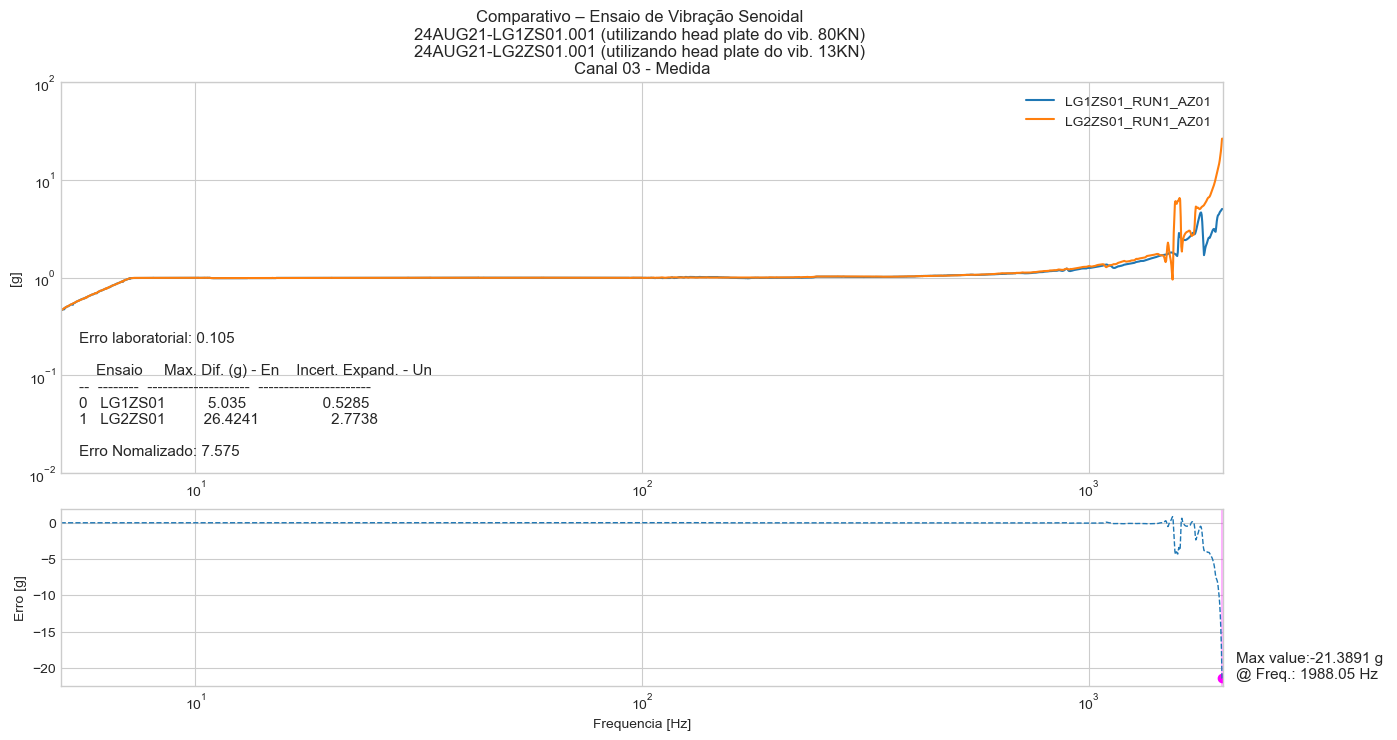

In [14]:
data = df_sine[['LG1ZS01_RUN1_AZ01', 'LG2ZS01_RUN1_AZ01']]
titulo = 'Comparativo – Ensaio de Vibração Senoidal \n\
24AUG21-LG1ZS01.001 (utilizando head plate do vib. 80KN) \n\
24AUG21-LG2ZS01.001 (utilizando head plate do vib. 13KN) \n\
Canal 03 - Medida'

output, En = comparativo_sine(data, erro_lab, titulo, print_output=print_output, size_text=size_text, xlim=xlim, ylim=ylim)

In [15]:
print(list(df_sine.columns))
print(sheet_names)

['LG1ZS01_RUN1_CTRL', 'LG1ZS01_RUN1_AZ01', 'LG2ZS01_RUN1_CTRL', 'LG2ZS01_RUN1_AZ01', 'LG2ZS01_RUN2_CTRL', 'LG2ZS01_RUN2_AZ01', 'LG2ZS01_RUN3_CTRL', 'LG2ZS01_RUN3_AZ01', 'LG2ZS01_RUN4_CTRL', 'LG2ZS01_RUN4_AZ01', 'LG2ZS01_RUN5_CTRL', 'LG2ZS01_RUN5_AZ01']
['24AUG21-LG1ZS01.001', '24AUG21-LG2ZS01.001', '24AUG21-LG2ZS01.002', '24AUG21-LG2ZS01.003', '24AUG21-LG2ZS01.004', '24AUG21-LG2ZS01.005', 'FULL']


                   Max. Dif. (g) - En  Incert. Expand. - Un
LG2ZS01_RUN1_CTRL               0.512                 0.054
LG2ZS01_RUN2_CTRL               0.530                 0.056

Erro Nomalizado: 0.233


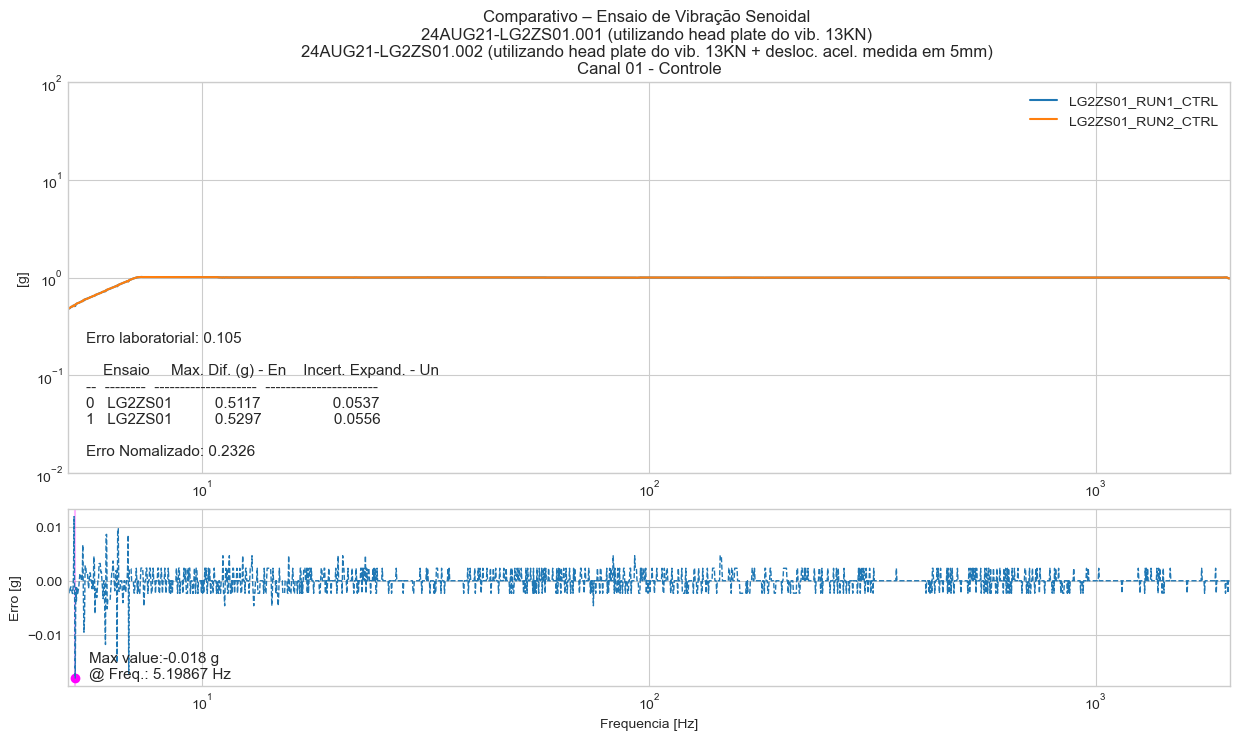

In [16]:
data = df_sine[['LG2ZS01_RUN1_CTRL', 'LG2ZS01_RUN2_CTRL']]
titulo = 'Comparativo – Ensaio de Vibração Senoidal \n\
24AUG21-LG2ZS01.001 (utilizando head plate do vib. 13KN) \n\
24AUG21-LG2ZS01.002 (utilizando head plate do vib. 13KN + desloc. acel. medida em 5mm) \n\
Canal 01 - Controle'

output, En = comparativo_sine(data, erro_lab, titulo, print_output=print_output, size_text=size_text, xlim=xlim, ylim=ylim)

                   Max. Dif. (g) - En  Incert. Expand. - Un
LG2ZS01_RUN1_AZ01              17.378                 1.824
LG2ZS01_RUN2_AZ01              18.030                 1.893

Erro Nomalizado: 0.248


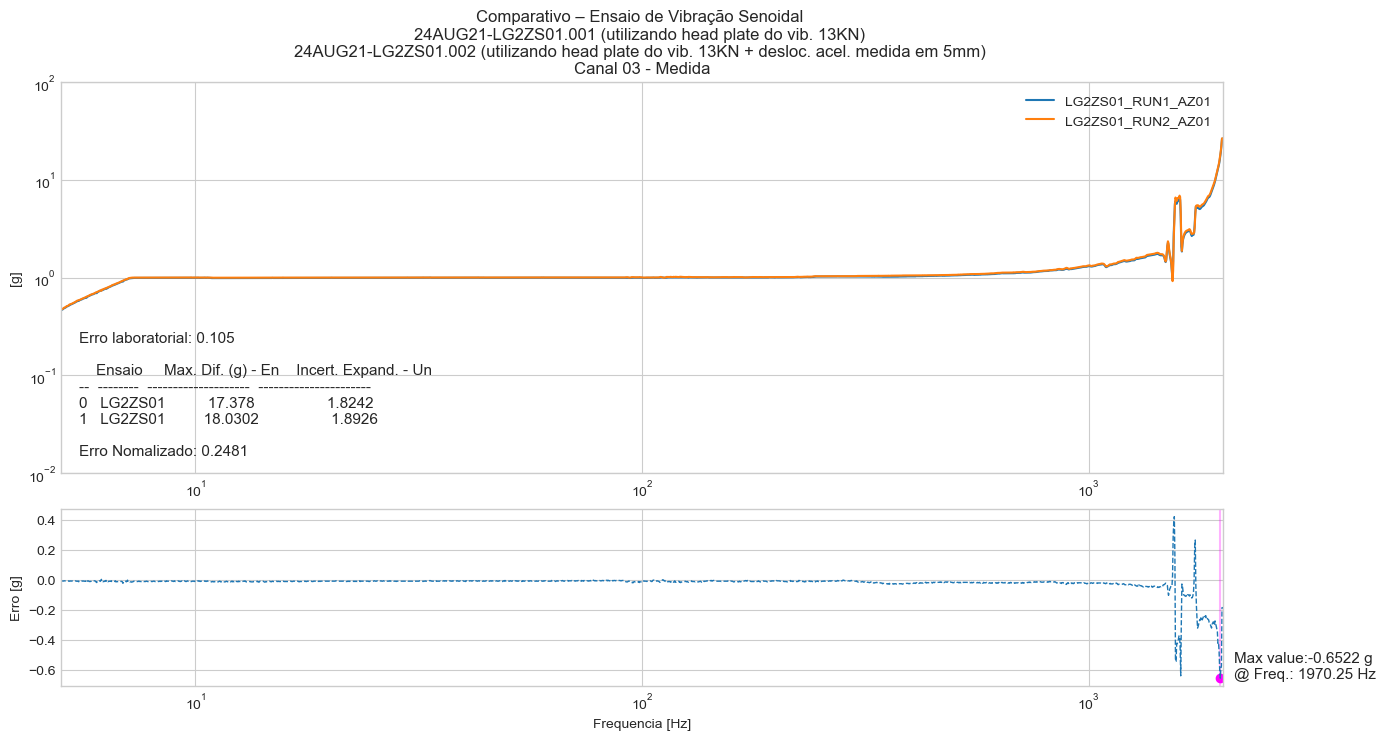

In [17]:
data = df_sine[['LG2ZS01_RUN1_AZ01', 'LG2ZS01_RUN2_AZ01']]
titulo = 'Comparativo – Ensaio de Vibração Senoidal \n\
24AUG21-LG2ZS01.001 (utilizando head plate do vib. 13KN) \n\
24AUG21-LG2ZS01.002 (utilizando head plate do vib. 13KN + desloc. acel. medida em 5mm) \n\
Canal 03 - Medida'

output, En = comparativo_sine(data, erro_lab, titulo, print_output=print_output, size_text=size_text, xlim=xlim, ylim=ylim)

In [18]:
print(list(df_sine.columns))
print(sheet_names)

['LG1ZS01_RUN1_CTRL', 'LG1ZS01_RUN1_AZ01', 'LG2ZS01_RUN1_CTRL', 'LG2ZS01_RUN1_AZ01', 'LG2ZS01_RUN2_CTRL', 'LG2ZS01_RUN2_AZ01', 'LG2ZS01_RUN3_CTRL', 'LG2ZS01_RUN3_AZ01', 'LG2ZS01_RUN4_CTRL', 'LG2ZS01_RUN4_AZ01', 'LG2ZS01_RUN5_CTRL', 'LG2ZS01_RUN5_AZ01']
['24AUG21-LG1ZS01.001', '24AUG21-LG2ZS01.001', '24AUG21-LG2ZS01.002', '24AUG21-LG2ZS01.003', '24AUG21-LG2ZS01.004', '24AUG21-LG2ZS01.005', 'FULL']


                   Max. Dif. (g) - En  Incert. Expand. - Un
LG2ZS01_RUN1_CTRL               0.512                 0.054
LG2ZS01_RUN3_CTRL               0.530                 0.056

Erro Nomalizado: 0.233


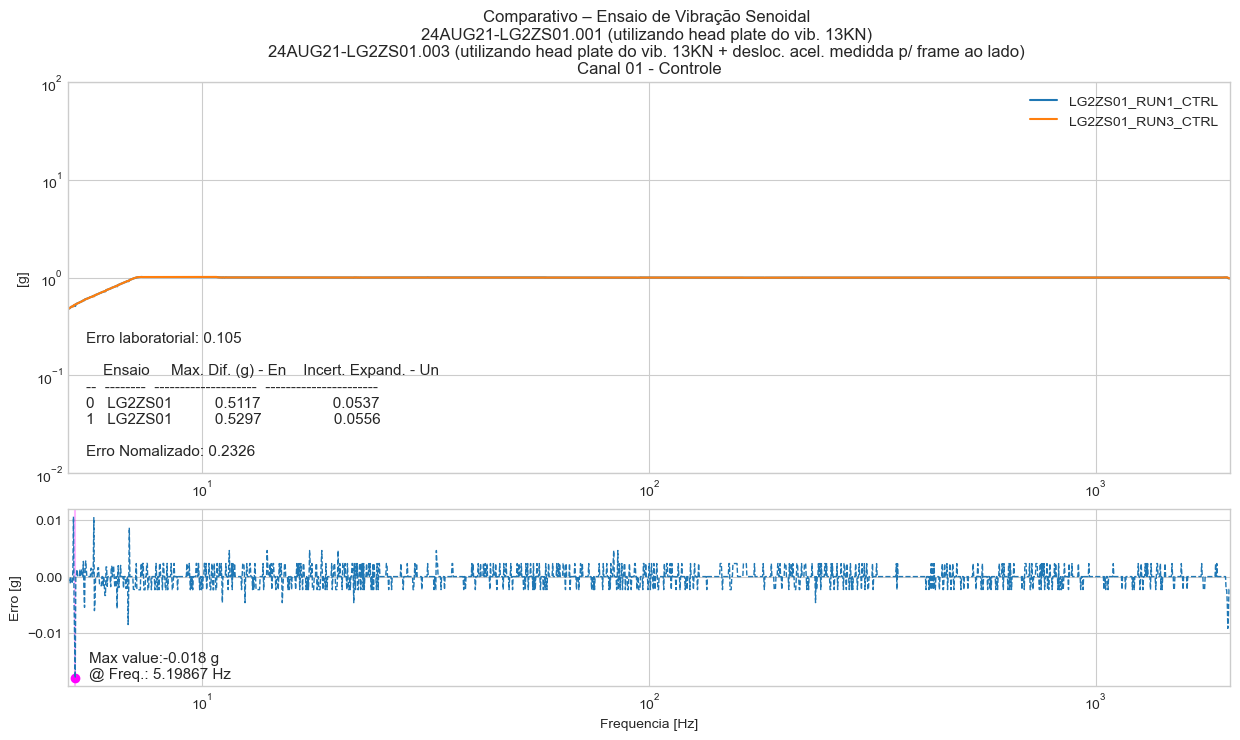

In [19]:
data = df_sine[['LG2ZS01_RUN1_CTRL', 'LG2ZS01_RUN3_CTRL']]
titulo = 'Comparativo – Ensaio de Vibração Senoidal \n\
24AUG21-LG2ZS01.001 (utilizando head plate do vib. 13KN) \n\
24AUG21-LG2ZS01.003 (utilizando head plate do vib. 13KN + desloc. acel. medidda p/ frame ao lado) \n\
Canal 01 - Controle'

output, En = comparativo_sine(data, erro_lab, titulo, print_output=print_output, size_text=size_text, xlim=xlim, ylim=ylim)

                   Max. Dif. (g) - En  Incert. Expand. - Un
LG2ZS01_RUN1_AZ01                4.15                 0.436
LG2ZS01_RUN3_AZ01                5.97                 0.627

Erro Nomalizado: 2.386


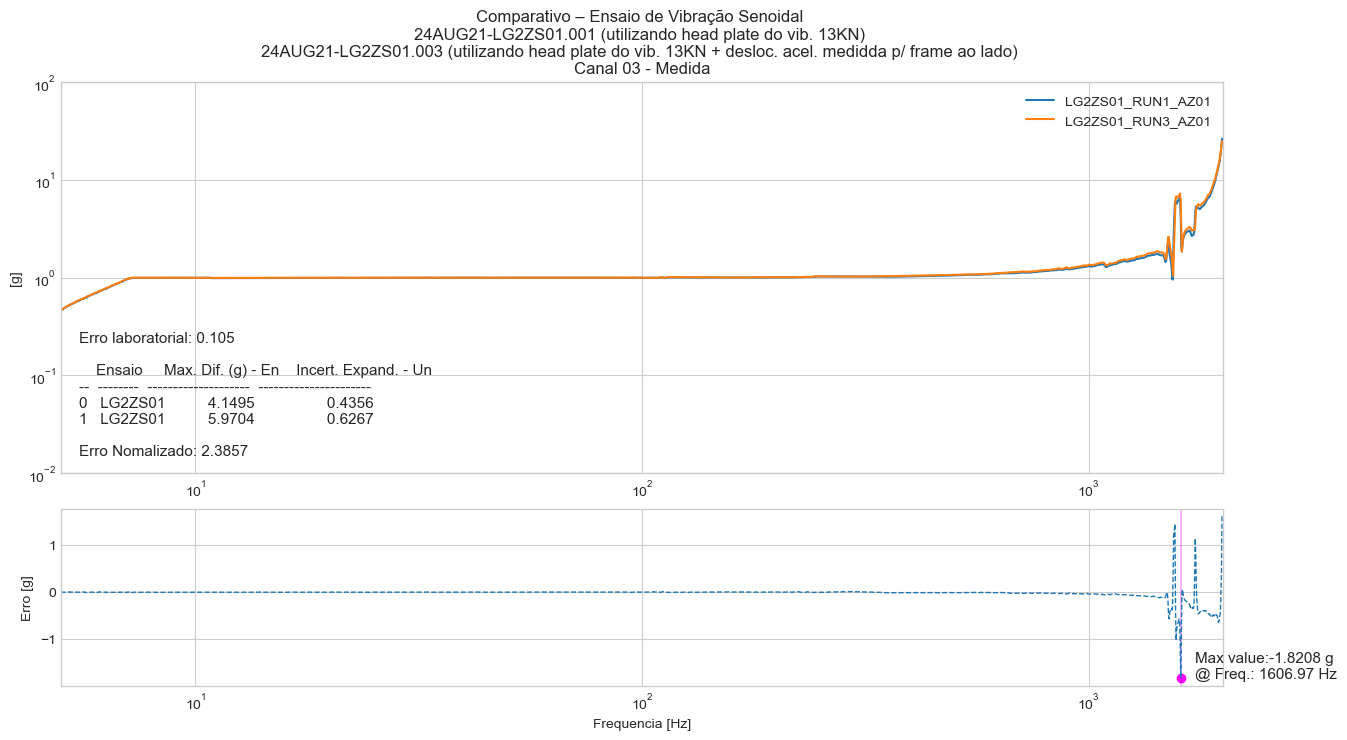

In [20]:
data = df_sine[['LG2ZS01_RUN1_AZ01', 'LG2ZS01_RUN3_AZ01']]
titulo = 'Comparativo – Ensaio de Vibração Senoidal \n\
24AUG21-LG2ZS01.001 (utilizando head plate do vib. 13KN) \n\
24AUG21-LG2ZS01.003 (utilizando head plate do vib. 13KN + desloc. acel. medidda p/ frame ao lado) \n\
Canal 03 - Medida'

output, En = comparativo_sine(data, erro_lab, titulo, print_output=print_output, size_text=size_text, xlim=xlim, ylim=ylim)

                   Max. Dif. (g) - En  Incert. Expand. - Un
LG2ZS01_RUN1_CTRL               0.948                 0.100
LG2ZS01_RUN4_CTRL               0.931                 0.098

Erro Nomalizado: 0.124


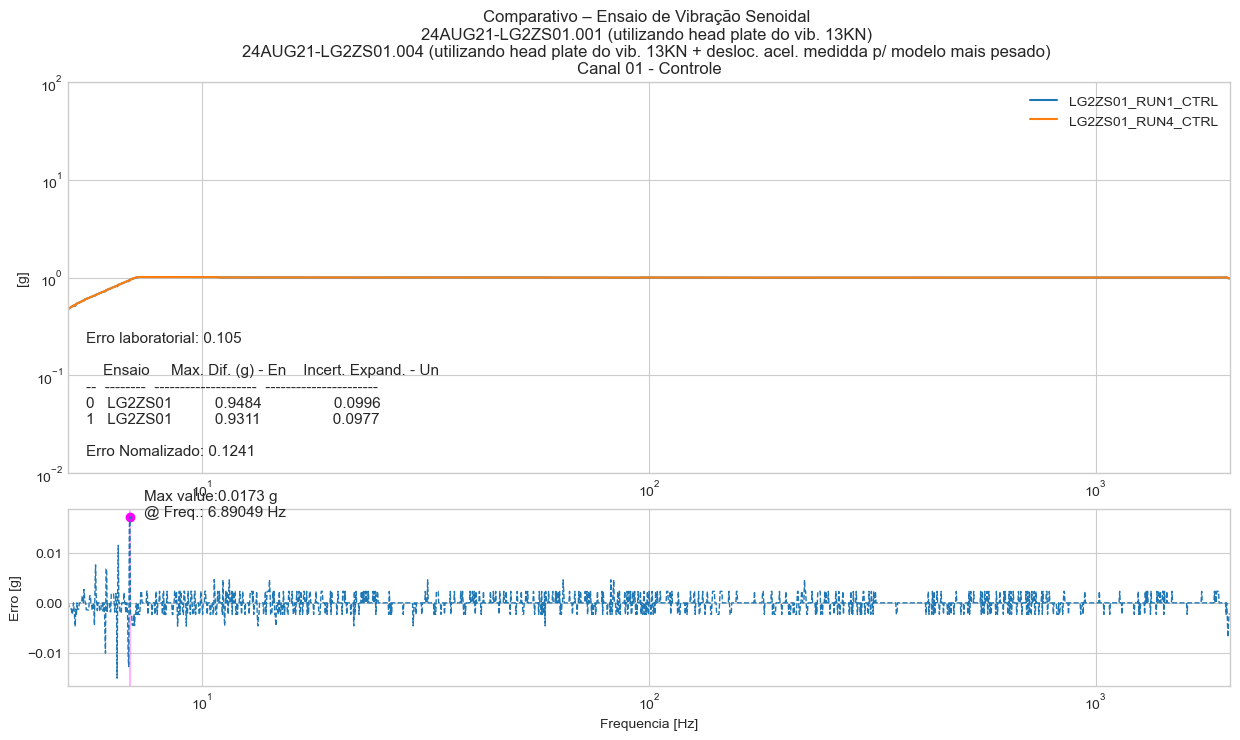

In [21]:
data = df_sine[['LG2ZS01_RUN1_CTRL', 'LG2ZS01_RUN4_CTRL']]
titulo = 'Comparativo – Ensaio de Vibração Senoidal \n\
24AUG21-LG2ZS01.001 (utilizando head plate do vib. 13KN) \n\
24AUG21-LG2ZS01.004 (utilizando head plate do vib. 13KN + desloc. acel. medidda p/ modelo mais pesado) \n\
Canal 01 - Controle'

output, En = comparativo_sine(data, erro_lab, titulo, print_output=print_output, size_text=size_text, xlim=xlim, ylim=ylim)

                   Max. Dif. (g) - En  Incert. Expand. - Un
LG2ZS01_RUN1_AZ01              26.424                 2.774
LG2ZS01_RUN4_AZ01              24.831                 2.607

Erro Nomalizado: 0.418


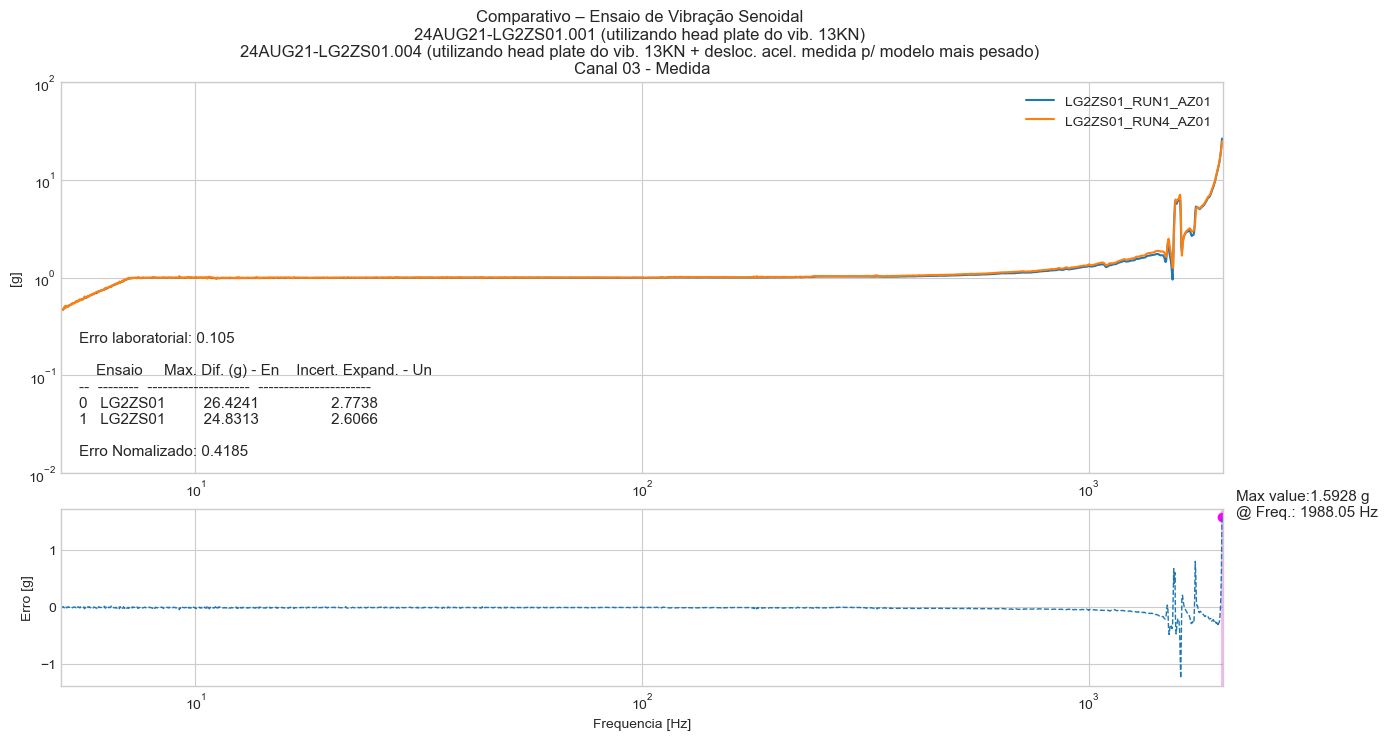

In [22]:
data = df_sine[['LG2ZS01_RUN1_AZ01', 'LG2ZS01_RUN4_AZ01']]
titulo = 'Comparativo – Ensaio de Vibração Senoidal \n\
24AUG21-LG2ZS01.001 (utilizando head plate do vib. 13KN) \n\
24AUG21-LG2ZS01.004 (utilizando head plate do vib. 13KN + desloc. acel. medida p/ modelo mais pesado) \n\
Canal 03 - Medida'

output, En = comparativo_sine(data, erro_lab, titulo, print_output=print_output, size_text=size_text, xlim=xlim, ylim=ylim)

                   Max. Dif. (g) - En  Incert. Expand. - Un
LG1ZS01_RUN1_CTRL               0.834                 0.088
LG2ZS01_RUN5_CTRL               0.818                 0.086

Erro Nomalizado: 0.124


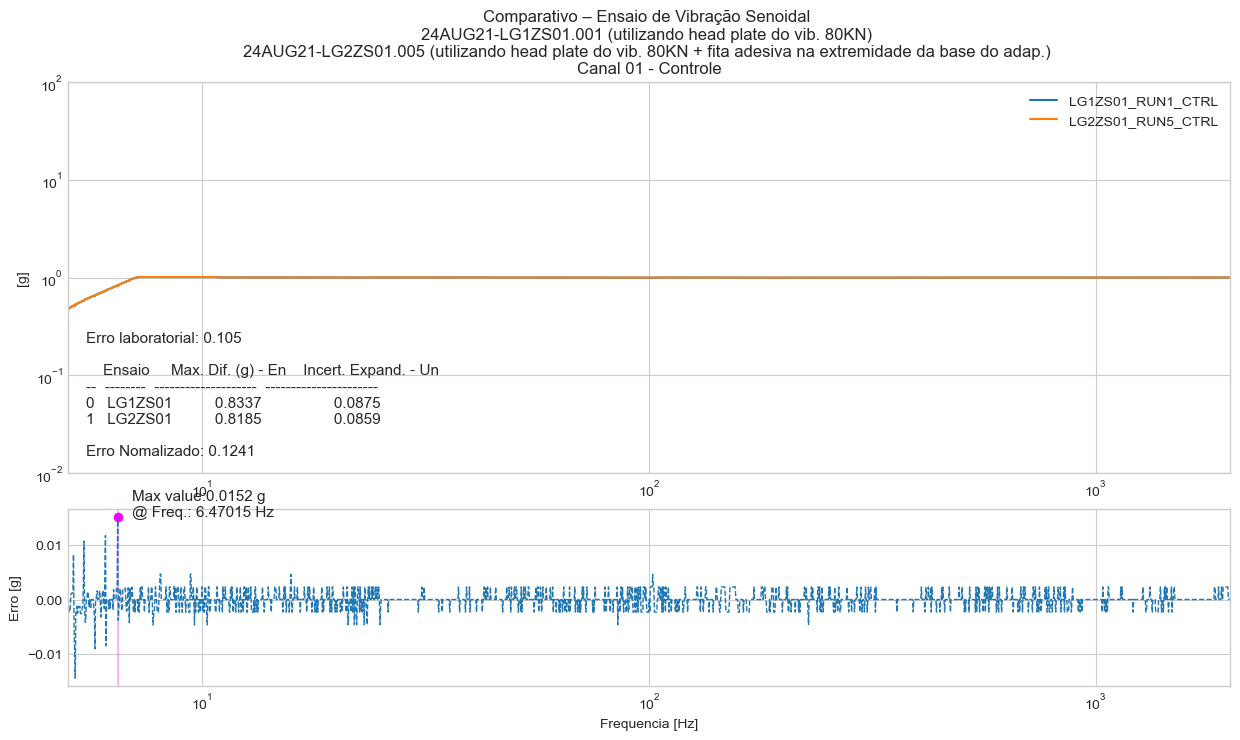

In [23]:
data = df_sine[['LG1ZS01_RUN1_CTRL', 'LG2ZS01_RUN5_CTRL']]
titulo = 'Comparativo – Ensaio de Vibração Senoidal \n\
24AUG21-LG1ZS01.001 (utilizando head plate do vib. 80KN) \n\
24AUG21-LG2ZS01.005 (utilizando head plate do vib. 80KN + fita adesiva na extremidade da base do adap.) \n\
Canal 01 - Controle'

output, En = comparativo_sine(data, erro_lab, titulo, print_output=print_output, size_text=size_text, xlim=xlim, ylim=ylim)

                   Max. Dif. (g) - En  Incert. Expand. - Un
LG1ZS01_RUN1_AZ01               5.035                 0.529
LG2ZS01_RUN5_AZ01               1.384                 0.145

Erro Nomalizado: 6.662


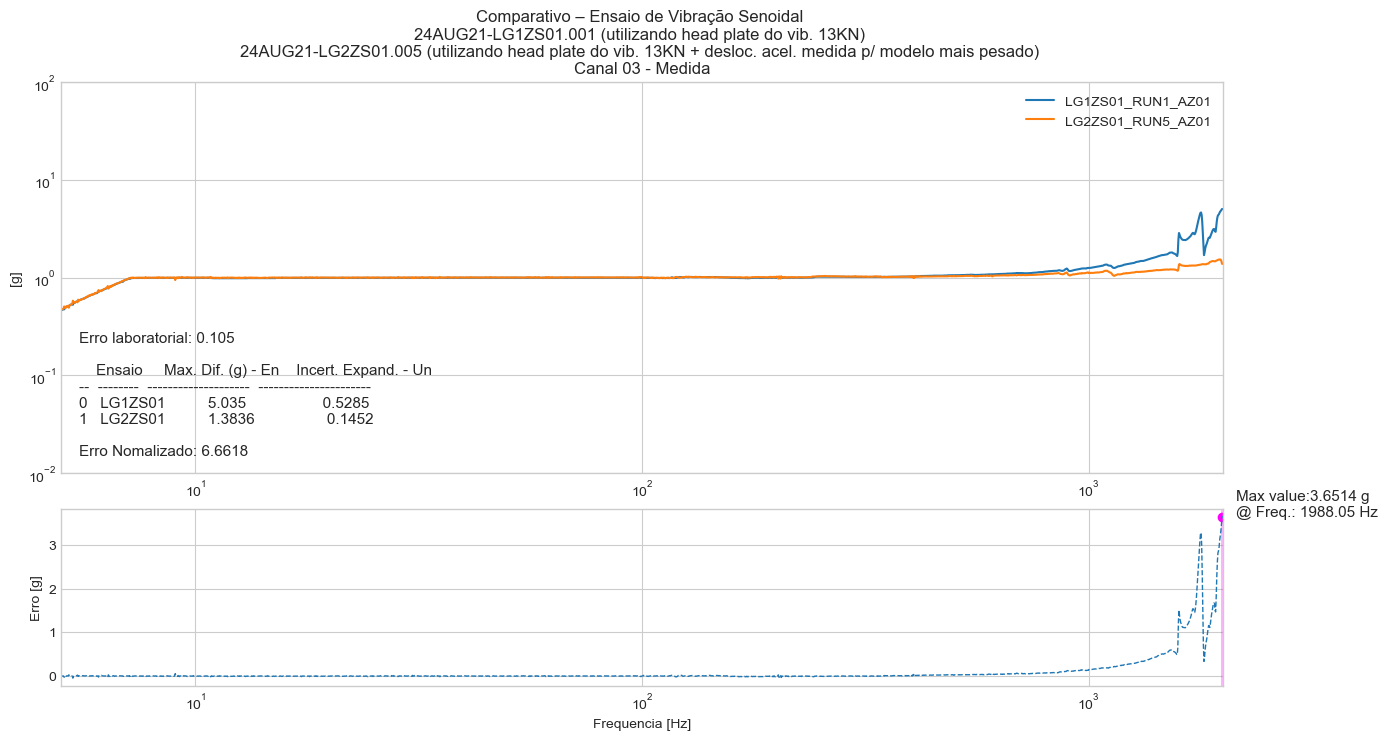

In [24]:
data = df_sine[['LG1ZS01_RUN1_AZ01', 'LG2ZS01_RUN5_AZ01']]
titulo = 'Comparativo – Ensaio de Vibração Senoidal \n\
24AUG21-LG1ZS01.001 (utilizando head plate do vib. 13KN) \n\
24AUG21-LG2ZS01.005 (utilizando head plate do vib. 13KN + desloc. acel. medida p/ modelo mais pesado) \n\
Canal 03 - Medida'

output, En = comparativo_sine(data, erro_lab, titulo, print_output=print_output, size_text=size_text, xlim=xlim, ylim=ylim)

***

# Especificando a frequencia para calculo do Erro normalizado

In [28]:
def error_by_freq(df, freq, erro_lab, print_output=True):
    """ erro laboratoriam em uma frequencia especifica
    return:
        max_1 = amplitude do acc1 na frequencia especificada
        max_2 = amplitude do acc2 na frequencia especificada
        En = Erro normalizado
    """
    idx = abs(df.index-freq).argsort()[0] # Indice com o valor mais proximo de freq
    df_temp =  df.iloc[idx]
    
    max_1 = df_temp[0]
    max_2 = df_temp[1]
    output = pd.DataFrame(index=data.columns)
    output['g @ freq.'] = [max_1, max_2]
    output['Incert. Expand.'] = [max_1 * erro_lab, max_2 * erro_lab]
    
    En = abs(output['g @ freq.'].diff()[1]) / np.sqrt((output['Incert. Expand.'] ** 2).sum()) 
    
    if print_output == True:
        print(f'{round(output,3)}\n\nErro Nomalizado: {round(En,3)} @ {freq}Hz')

        # plot
        df.plot()
        plt.axvline(freq, color='magenta', linestyle='--')
        plt.ylabel('g')
    
    return max_1, max_2, En



def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    return array[idx]

def plot_erro_by_freq(data, erro_normalizado):
    lista = []
    for i in notebook.tqdm(range(len(data))):
        g1, g2, en = error_by_freq(data, i, erro_lab, print_output=False)
        lista.append((i, en))
        
    df_erro = pd.DataFrame(lista, columns=['Freq.[Hz]', 'Erro Normalizado'])
    df_erro = df_erro.set_index('Freq.[Hz]')
    
    freq_lim = np.array(abs(df_erro - erro_normalizado)).argmin()
    df_erro.plot()
    plt.axvline(freq_lim, c='magenta', linestyle='-', alpha=0.3)
    plt.axhline(erro_normalizado, c='magenta', linestyle='-', alpha=0.3)
    plt.ylabel('Erro Normalizado')
    plt.scatter(freq_lim, erro_normalizado, c='magenta', linewidths=1)
    plt.annotate(f'Erro Normalizado: {round(erro_normalizado,4)} \n@ Freq.: {freq_lim} Hz', # this is the text
                     (freq_lim, erro_normalizado), # this is the point label
                     textcoords='offset points', # how to position the text
                     xytext=(10,-25), # distance from text to points (x,y)
                     ha='left',
                     size=size_text); # horizontal alignment can be left, right or center
    plt.title(f'{data.columns[0]} x {data.columns[1]} \n')
    
    return df_erro

  0%|          | 0/1995 [00:00<?, ?it/s]

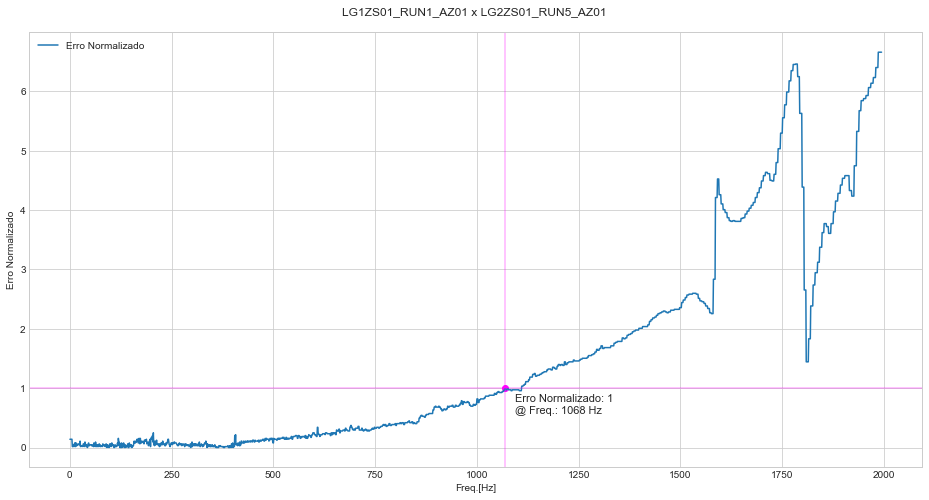

In [32]:
erro_lab = 0.104970601724674
data = df_sine[['LG1ZS01_RUN1_AZ01', 'LG2ZS01_RUN5_AZ01']]

erro_norm = plot_erro_by_freq(data, erro_normalizado=1)

***